# Mixture Density Networks in TensorFlow
An implementation of MDNs adapted from Andrej Karpathy's [example](https://github.com/karpathy/randomfun). My version is powered by [TensorFlow](https://www.tensorflow.org/versions/master/get_started/index.html)

Mixture Density Networks are just like vanilla neural networks but they return estimates of uncertainty on their predictions. Karpathy writes:

"The core idea is to have a Neural Net that predicts an entire (and possibly complex)
distribution. In this example we're predicting a mixture of gaussians distributions via
its sufficient statistics (the means and diagonal covariances), which are on the last
layer of the neural network. This means that the network knows what it doesn't know:
it will predict diffuse distributions in situations where the target variable is very
noisy, and it will predict a much more peaky distribution in nearly deterministic parts."

Karpathy took his version from Bishop's Machine Learning textbook (1994)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.contrib import distributions as ds
%matplotlib inline

## Generate data

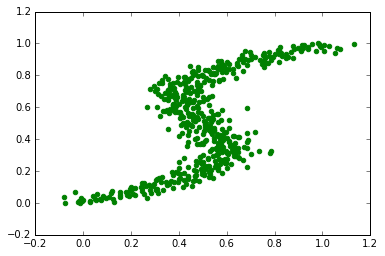

In [2]:
N = 500
X = np.linspace(0, 1, N)
T = X + 0.3 * np.sin(2 * np.pi * X) + np.random.normal(0., 0.075, N)
X, T = T, X
plt.scatter(X, T,color='g')

## Set hyperparameters

In [3]:
input_size = 1   # size of input (x)
target_size = 1  # size of target (t)
hidden_size = 30 # size of hidden layer
K = 3            # number of mixture components

## Initialize tensors for weights and biases

In [32]:
tf.reset_default_graph()

x = tf.placeholder("float", shape=[None, input_size])
t = tf.placeholder("float", shape=[None, target_size])

with tf.variable_scope('hidden'):
    W = tf.Variable(tf.truncated_normal([input_size, hidden_size], stddev=0.25))
    b = tf.Variable(tf.truncated_normal([hidden_size], stddev=0.01))
    h = tf.nn.tanh(tf.matmul(x, W) + b)

with tf.variable_scope('mdn'):
    with tf.variable_scope('pi'):
        W = tf.Variable(tf.truncated_normal([hidden_size, K], stddev=0.25))
        b = tf.Variable(tf.truncated_normal([K], stddev=0.01))
        pi = tf.nn.softmax(tf.matmul(h, W) + b)

    with tf.variable_scope('mu'):
        W = tf.Variable(tf.truncated_normal([hidden_size, K], stddev=0.25))
        b = tf.Variable(tf.truncated_normal([K], stddev=0.01))
        mu = tf.matmul(h, W) + b

    with tf.variable_scope('sigma'):
        W = tf.Variable(tf.truncated_normal([hidden_size, K], stddev=0.25))
        b = tf.Variable(tf.truncated_normal([K], stddev=0.01))
        sigma = tf.exp(tf.matmul(h, W) + b)

    with tf.variable_scope('mixture'):
        components = []
        mu_components = tf.unstack(mu, axis=1)
        sigma_components = tf.unstack(sigma, axis=1)
        for i in range(K):
            components.append(ds.Normal(loc=mu_components[i], scale=sigma_components[i]))
        mixture = ds.Mixture(cat=ds.Categorical(probs=pi), components=components)

In [71]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import distributions as ds

tf.reset_default_graph()

pi = tf.placeholder('float', [None, 2, K])
mu = tf.placeholder('float', [None, K, 2])
sigma = tf.placeholder('float', [None, K, 2])
t = tf.placeholder('float', [None, 2])

cat = ds.Categorical(probs=pi)
components = []
mu_components = tf.unstack(mu, axis=1)
sigma_components = tf.unstack(sigma, axis=1)
for i in range(K):
    components.append(ds.Normal(loc=mu_components[i], scale=sigma_components[i]))
mixture = ds.Mixture(cat=cat, components=components)

sess = tf.InteractiveSession()
mixture.prob(t).eval(feed_dict={
    pi: [[[1., 1., 1], [1., 1., 1.]],
         [[1., 1., 1], [1., 1., 1.]]],
    mu: [[[1., 1.], [1., 1.], [1., 1.]],
         [[1., 1.], [1., 1.], [1., 1.]]],
    sigma: [[[1., 1.], [1., 1.], [1., 1.]],
            [[1., 1.], [1., 1.], [1., 1.]]],
    t: [[1., 1.], [2., 2.]]
})

array([[ 0.39894223,  0.39894223],
       [ 0.2419707 ,  0.2419707 ]], dtype=float32)

## Loss function

In [5]:
loss = -tf.reduce_sum(tf.log(mixture.prob(t)))

In [7]:
mixture.prob(t)

<tf.Tensor 'Mixture_1/prob/Exp:0' shape=(?, ?) dtype=float32>

## Train

In [6]:
train_step = tf.train.AdagradOptimizer(1e-2).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

xbatch = X.reshape((N,input_size))
tbatch = T.reshape((N,target_size))
for i in range(20000):
    if i%1000 == 0:
        train_loss = loss.eval(feed_dict={x:xbatch, t: tbatch})
        print "step %d, training loss %g"%(i, train_loss)
    train_step.run(feed_dict={x: xbatch, t: tbatch})

print "training loss %g" % loss.eval(feed_dict={x: xbatch, t: tbatch})

step 0, training loss 267632
step 1000, training loss 15895.8
step 2000, training loss 15370.9
step 3000, training loss 15288.4
step 4000, training loss 15251.6


KeyboardInterrupt: 

## Approximate

In [ ]:
def approximate(xbatch):
    mus = mu.eval()        # [? x K]
    pis = pi.eval()        # [? x K]
    best_mus = []
    for i in xrange(len(xbatch)):
        best_k = pis[i].argmax()
        best_mus.append(mus[i, best_k])
    return best_mus

plt.scatter(X, T, color='g')
plt.scatter(xbatch, approximate(xbatch), color='r')

## Test map_fn

In [ ]:
import time

tf.reset_default_graph()
input = tf.placeholder(tf.float32, [None])
output = tf.map_fn(fun, input, dtype=tf.float32)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

total_start = time.time()
for i in range(1):
    output.eval(feed_dict={
        input: np.ones(1000000, dtype=np.float32)
    })
print time.time() - total_start

In [ ]:
import time

tf.reset_default_graph()
input = tf.placeholder(tf.float32, [None])
output = input * input

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

total_start = time.time()
for i in range(1):
    output.eval(feed_dict={
        input: np.ones(1000000, dtype=np.float32)
    })
print time.time() - total_start